<b><h2 style="text-align:center;">COMM493 - Coding AI for Business</h2><b>

<h5 style="text-align:center;">Assignment 1 - Linear Learner Data Identification & Preparation</h5>

<h5 style="text-align:center;">Maxwell Brookes - 20244724</h5>

<h5 style="text-align:center;">Due on Feb 9</h5>


<b><h4>0: Intro</h4><b>
<h5>Data: <a href="https://www.kaggle.com/datasets/smac91/hotel-bookings/data">hotel_bookings</a> dataset contains ~120k rows and 32 columns of hotel book information in csv format.</h5>
<h5>Goal: use binary classification to predict booking cancellations.</h5>


<b><h4>1: Load Modules & Tools:</h4><b>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
import time
import numpy as np  # for linear algebra
import pandas as pd  # for loading data

import seaborn as sns  # for heatmap
import matplotlib.pyplot as plt  # for visualizations

from sklearn.model_selection import train_test_split  # for splitting dataset
from sklearn.feature_selection import VarianceThreshold # for cleaning data

# AWS & SageMaker Libraries for Model Training and Deployment
from botocore.exceptions import ClientError
import boto3
import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.linear_learner import LinearLearner  # SageMaker's built-in Linear Learner algorithm
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Successfully Loaded All Modules")

[02/08/25 01:55:02] INFO     Found credentials from IAM Role:                                   ]8;id=59586;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=980683;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Successfully Loaded All Modules



<b><h4>2: Load Dataset into pandas dataframe:</h4><b>

In [2]:
# dataset = https://www.kaggle.com/datasets/smac91/hotel-bookings, implementation = https://www.kaggle.com/datasets/somnathnaskar/hotel-booking-dataset/data
df = pd.read_csv('hotel_bookings.csv')  # Load the CSV file into a DataFrame
target_column = 'is_canceled'  # define target column (what I want to predict)


<b><h4>3: Preview Dataset:</h4><b>

In [3]:
print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False))  # list first 10 row and columns

Data Shape: (119390, 32)
Data Preview:
       hotel  is_canceled  lead_time  arrival_date_year arrival_date_month
Resort Hotel            0        342               2015               July
Resort Hotel            0        737               2015               July
Resort Hotel            0          7               2015               July
Resort Hotel            0         13               2015               July
Resort Hotel            0         14               2015               July
Resort Hotel            0         14               2015               July
Resort Hotel            0          0               2015               July
Resort Hotel            0          9               2015               July
Resort Hotel            1         85               2015               July
Resort Hotel            1         75               2015               July



<b><h4>4: Drop Columns:</h4><b>
<h5>Drop 'agent', 'company', and 'distribution_channel' because they only inform about the source of the booking. In use bookings will only come from one source.</h5>
<h5>Drop 'arrival_date_week_number', 'arrival_date_year', and 'arrival_date_day_of_month' because 'lead_time' already captures necessary time information.</h5>
<h5>Drop 'reservation_status_date' because 'lead_time' already captures when the reservation was made.</h5>
<h5>Drop'country' because the analysis is not based on location.</h5>
<h5>Drop 'days_in_waiting_list' because most values are zero.</h5>
<h5>Drop 'meal' because a small kingston hotel will not have multiple meal options.</h5>
<h5>Drop 'reservation_status' because conveys the same information as 'is_cancelled'.</h5>
<h5>Drop 'reserved_room_type' and 'assigned_room_type' because a small kingston business will not have many room options.</h5>
<h5>Drop 'hotel' because a small kingston hotel is not comparable to a resort hotel.</h5>

In [4]:
# print(df.columns)  # Check available columns
# unique_dict = {col: df[col].unique() for col in df.columns}
# for col, uniques in unique_dict.items():
#     print(f"{col}: {uniques}")

columns_to_drop = ['agent', 'company', 'arrival_date_week_number', 'country',
                   'distribution_channel', 'days_in_waiting_list', 'meal',
                   'reservation_status', 'reservation_status_date', 'arrival_date_year',
                   'arrival_date_day_of_month', 'reserved_room_type', 'assigned_room_type'] # maybe add is_repeated_guest 
df.drop(columns_to_drop, axis=1, inplace=True)  # drop columns without having to create a new pandas data frame

# only use City Hotels
df.drop(df[df['hotel'] == 'Resort Hotel'].index, inplace=True)  # Drop all rows where 'hotel' is 'Resort Hotel'
df.drop(['hotel'], axis=1, inplace=True)  # Drop the 'hotel' column since only 'City Hotel' remains

df.drop_duplicates(keep='first', inplace=True)  # Drop duplicate rows, keeping only the first occurrence

print('Data Shape:', df.shape)

Data Shape: (50680, 18)



<b><h4>5: Encode Categorial Features</h4><b>

In [5]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    if df[col].nunique() > 6:  # Frequency Encoding
        freq_encoding = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq_encoding)
    else:  # One-Hot Encoding
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df.drop(columns=[col], inplace=True)
        for dummy_col in dummies.columns:
            df[dummy_col] = dummies[dummy_col]
assert len(df.select_dtypes(include=[np.number]).columns) == len(df.columns), "Data contains non-numeric columns."


<b><h4>6: Further Cleaning (Rows, Unrealistic, Outliers, ...):</h4><b>

In [6]:
df['children'].fillna(0, inplace=True)  # Replace NaN values in 'children' with 0

# remove low variance features
selector = VarianceThreshold(threshold=0.01)
df_reduced = selector.fit_transform(df)
selected_features = df.columns[selector.get_support(indices=True)]
df = pd.DataFrame(df_reduced, columns=selected_features)

# remove outliers where value > mean + 3*standard deviation
for col in df.columns:
    upper_limit = df[col].quantile(0.997)
    lower_limit = df[col].quantile(0.003)
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

assert (not df.isnull().values.any()), 'Data contains null values.'  # make sure that there are no null values

df.reset_index(drop=True, inplace=True)  # Reset the indicies after all modifications

print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False))  # list first 10 row and columns

Data Shape: (50680, 18)
Data Preview:
 is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  adults
         0.0        6.0                      0.0                   2.0     1.0
         1.0       88.0                      0.0                   4.0     2.0
         1.0       65.0                      0.0                   4.0     1.0
         1.0       92.0                      2.0                   4.0     2.0
         1.0      100.0                      0.0                   2.0     2.0
         1.0       79.0                      0.0                   3.0     2.0
         0.0        3.0                      0.0                   3.0     1.0
         1.0       63.0                      1.0                   3.0     1.0
         1.0       62.0                      2.0                   3.0     2.0
         0.0       43.0                      0.0                   2.0     2.0



<b><h4>7: Correlation Analysis:</h4><b>
<h5>Few valriables have a strong correlations with 'is_canceled', implying that additional high quality data is required.</h5>
<h5>Target business will have to collect data as this venture progresses.</h5>

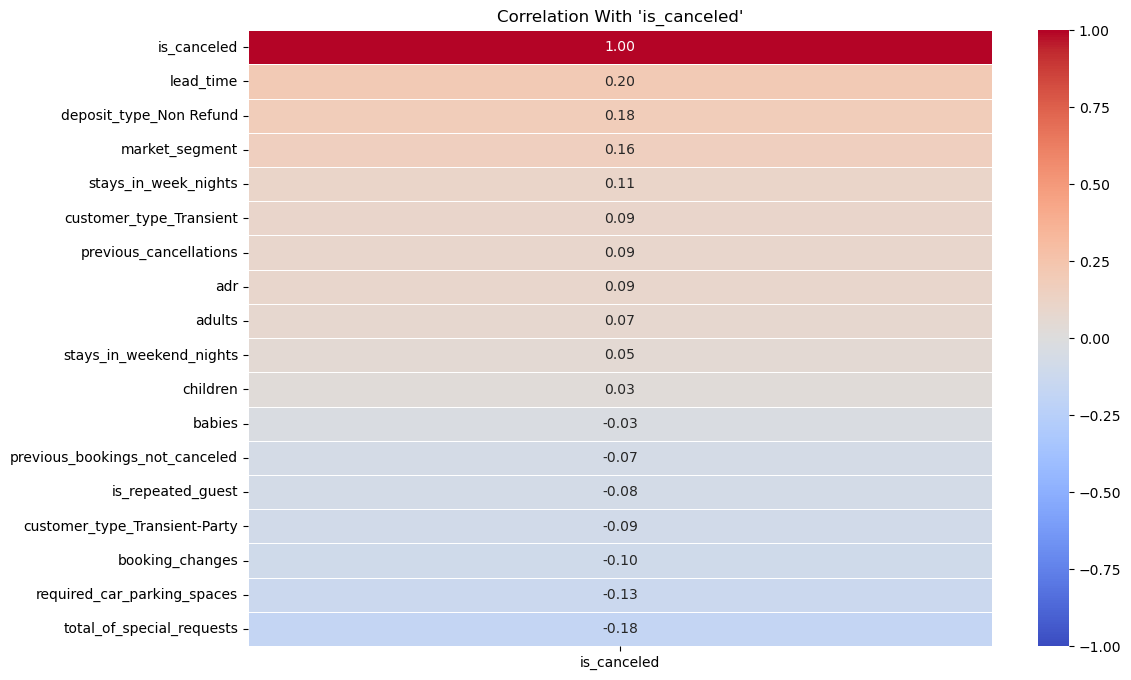

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True)[target_column].sort_values(ascending=False).to_frame(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation With \'is_canceled\'')
plt.show()
plt.close()


<b><h4>8: Split Data For Training and Evaluation:</h4><b>

In [8]:
x = df.drop(columns=[target_column])  # Features (independent variables)
y = df[target_column]  # Target variable (what I want to predict)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.15, random_state=42)  # 85/15 split, random_state is fixed for reproducibility

print(x_train.shape, x_eval.shape, y_train.shape, y_eval.shape)

(43078, 17) (7602, 17) (43078,) (7602,)



<b><h4>9: Prepare SageMakerAI</h4><b>

In [9]:
sagemaker_session = sagemaker.Session()  # Initialize a SageMaker session

role = get_execution_role()  # Get IAM role associated with SageMaker

bucket = sagemaker_session.default_bucket()  # Default S3 bucket assigned by SageMaker
region = sagemaker_session.boto_region_name  # AWS region of the session
prefix = 'sagemaker/hotel_bookings'  # Folder path in S3

train_data = pd.concat([y_train, x_train], axis=1)
validation_data = pd.concat([y_eval, x_eval], axis=1)

# Define filenames for local storage
train_file = 'hotel_bookings_train.csv'
validation_file = 'hotel_bookings_validation.csv'

# Save training and validation data to CSV files (no headers, no index)
train_data.to_csv(train_file, index=False, header=False)
validation_data.to_csv(validation_file, index=False, header=False)

# Upload datasets to Amazon S3 and retrieve their S3 locations
train_uri = sagemaker_session.upload_data(path=train_file, bucket=bucket, key_prefix=prefix)
validation_uri = sagemaker_session.upload_data(path=validation_file, bucket=bucket, key_prefix=prefix)

# Print the S3 paths of uploaded datasets for reference
print('Training data uploaded to:', train_uri)
print('Validation data uploaded to:', validation_uri)

[02/08/25 01:55:05] INFO     Found credentials from IAM Role:                                   ]8;id=515157;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=55909;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/08/25 01:55:06] INFO     Found credentials from IAM Role:                                   ]8;id=802190;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=837787;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Training data uploaded to: s3://sagemaker-us-east-1-086946010973/sagemaker/hotel_bookings/hotel_bookings_train.csv
Validation data uploaded to: s3://sagemaker-us-east-1-086946010973/sagemaker/hotel_bookings/hotel_bookings_validation.csv



<b><h4>10: Train Binary-Classification Model</h4><b>

In [10]:
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

linear_learner = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Set hyperparameters for the binary classification task.
linear_learner.set_hyperparameters(
    feature_dim=x.shape[1],
    predictor_type='binary_classifier',  # ensure type is binary_classifier
    mini_batch_size=32,  # Good mix between speed and performance
    epochs=10,  # Increase number of epochs
    learning_rate=0.01,  # Good mix between speed and performance
    optimizer='adam',  # Handles sparse and noisy data well. Provides fast convergence with stable updates.
    binary_classifier_model_selection_criteria='accuracy',  # Use accuracy for model selection
    loss='logistic',  # Ideal loss function for binary classification (probabilistic outputs, convex for optimization).
    l1=0.001,  # Pushes some feature weights to zero which increases stability and reduces irrelevant features.
    early_stopping_patience=3,  # Enable early stopping. If model converges early, stop training to save money.
    early_stopping_tolerance=0.001,  # Set tolerance for early stopping
)

train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# The fit method starts the training process on SageMaker using the provided training and validation data.
linear_learner.fit({'train': train_input, 'validation': validation_input})

print("Model training complete!")

[02/08/25 01:55:07] INFO     Same images used for training and inference. Defaulting to image     ]8;id=514154;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=611068;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=31745;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=989353;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=832051;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=842259;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[02/08/25 01:55:08] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=968748;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=488918;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=246811;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=945638;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-02-08-01-55-08-243                                                

2025-02-08 01:55:09 Starting - Starting the training job...
..25-02-08 01:55:24 Starting - Preparing the instances for training.
..25-02-08 01:55:48 Downloading - Downloading input data.
.....02-08 01:56:23 Downloading - Downloading the training image.
Docker entrypoint called with argument(s): trainmpleted. Training in progress..
Running default environment configuration script
[02/08/2025 01:57:48 INFO 139920007419712] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '


<b><h4>11: Deploy The Model</h4><b>

In [11]:
session = Session()                 # High-level SageMaker session
sm_client = boto3.client("sagemaker")
endpoint_name = "binary-learner-endpoint"

# 1. Use built-in waiter for InService (optional, but handy for waiting on creation)
endpoint_in_service_waiter = sm_client.get_waiter('endpoint_in_service')

def delete_endpoint_and_config(endpoint_name: str, wait_for_deletion: bool = True) -> None:
    # 1. Delete endpoint (if it exists).
    try:
        endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_status = endpoint_desc["EndpointStatus"]
        # If the endpoint is Creating or Updating, wait for it to become InService before deleting.
        if endpoint_status in ("Creating", "Updating"):
            logger.info(f"Endpoint '{endpoint_name}' is in '{endpoint_status}' state. Waiting before delete.")
            endpoint_in_service_waiter.wait(EndpointName=endpoint_name)  # Waits until 'InService'
        # Now delete
        logger.info(f"Deleting endpoint: {endpoint_name}")
        sm_client.delete_endpoint(EndpointName=endpoint_name)
    except ClientError as e:
        # If the endpoint was never found, ignore the error. Otherwise, re-raise.
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e
    # 2. Delete endpoint config (if it exists).
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleting endpoint configuration: {endpoint_name}")
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint config '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e
    # 3. Optionally poll for deletion. (There's no built-in waiter for deletion.)
    #    Below is a simple polling strategy for demonstration.
    if wait_for_deletion:
        logger.info("Waiting for endpoint & configuration to be deleted...")
        for _ in range(30):
            endpoint_exists = True
            endpoint_config_exists = True
            # Check endpoint
            try:
                sm_client.describe_endpoint(EndpointName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_exists = False
            # Check endpoint config
            try:
                sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_config_exists = False
            if not endpoint_exists and not endpoint_config_exists:
                logger.info("Endpoint and endpoint config fully deleted.")
                break
            logger.info("Endpoint or endpoint config still deleting... sleeping 10s.")
            time.sleep(10)
        else:
            logger.warning("Endpoint or endpoint config not fully deleted after 30 checks.")


def delete_model(model_name: str, wait_for_deletion: bool = True) -> None:
    try:
        sm_client.describe_model(ModelName=model_name)
        logger.info(f"Deleting model: {model_name}")
        sm_client.delete_model(ModelName=model_name)
    except ClientError as e:
        if "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Model '{model_name}' does not exist or is already deleted.")
        else:
            raise e
    if wait_for_deletion:
        # There's no official 'model deleted' waiter, so we poll:
        for _ in range(20):
            try:
                sm_client.describe_model(ModelName=model_name)
                logger.info("Model still deleting... sleeping 5s.")
                time.sleep(5)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    logger.info("Model fully deleted.")
                    break
        else:
            logger.warning("Model was not deleted after waiting.")


delete_endpoint_and_config(endpoint_name)
# If your model is also named the same, you might do:
# delete_model(endpoint_name)

predictor = linear_learner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

logger.info(f"Endpoint '{endpoint_name}' deployed successfully and ready for inference.")

[02/08/25 02:05:05] INFO     Endpoint 'binary-learner-endpoint' does not exist or has already been   ]8;id=570595;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=543732;file:///tmp/ipykernel_15478/49064531.py#23\23]8;;\
                             deleted.                                                                              

                    INFO     Endpoint config 'binary-learner-endpoint' does not exist or has already ]8;id=949938;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=461728;file:///tmp/ipykernel_15478/49064531.py#33\33]8;;\
                             been deleted.                                                                         

                    INFO     Waiting for endpoint & configuration to be deleted...                   ]8;id=939946;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=941087;file:///tmp/ipykernel_15478/49064531.py#39\39]8;;\

                    INFO     Endpoint and endpoint config fully deleted.                             ]8;id=424056;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=556882;file:///tmp/ipykernel_15478/49064531.py#56\56]8;;\

                    INFO     Creating model with name: linear-learner-2025-02-08-02-05-05-815       ]8;id=639319;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=756151;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[02/08/25 02:05:06] INFO     Creating endpoint-config with name binary-learner-endpoint             ]8;id=444956;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=375897;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name binary-learner-endpoint                    ]8;id=636410;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=748519;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

-------!

[02/08/25 02:09:07] INFO     Endpoint 'binary-learner-endpoint' deployed successfully and ready for ]8;id=355200;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=401288;file:///tmp/ipykernel_15478/49064531.py#102\102]8;;\
                             inference.                                                                            


<b><h4>12: Test Model On Training Data</h4><b>


 **Evaluation Metrics:**
  Accuracy:  0.7655
  Precision: 0.6688
  Recall:    0.4914
  F1 Score:  0.5665

**Classification Report:**
              precision    recall  f1-score   support

Not Canceled       0.79      0.89      0.84      5231
    Canceled       0.67      0.49      0.57      2371

    accuracy                           0.77      7602
   macro avg       0.73      0.69      0.70      7602
weighted avg       0.76      0.77      0.75      7602


**Confusion Matrix (Raw Values):**
[[4654  577]
 [1206 1165]]


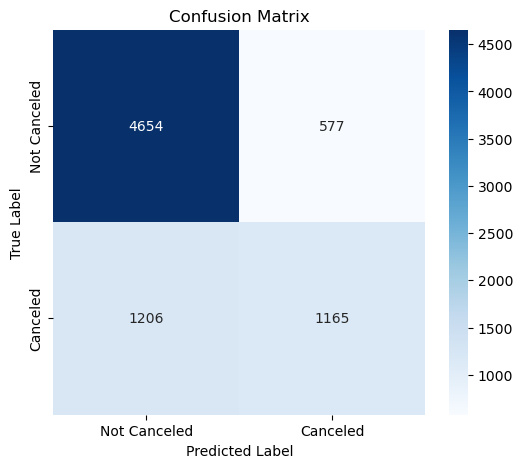

{'Accuracy': 0.7654564588266246, 'Precision': 0.6687715269804823, 'Recall': 0.4913538591311683, 'F1 Score': 0.5664964745927547}


In [12]:
def evaluate_deployed_classifier(predictor, x_eval, y_eval):
    predictor.serializer = CSVSerializer()  # Ensure the predictor uses the correct serialization

    # Copy test features and labels
    x_test = x_eval.copy()
    y_test = y_eval.copy()

    predictions = predictor.predict(x_test.values)  # Get predictions from the deployed endpoint

    # Ensure correct extraction of predicted labels
    try:
        predicted_labels = [int(result["predicted_label"]) for result in predictions["predictions"]]
    except (KeyError, TypeError) as e:
        print(f"Error extracting predictions: {e}")
        return None  # Stop execution if predictions are not correctly formatted

    # Compute evaluation metrics
    acc = accuracy_score(y_test, predicted_labels)
    prec = precision_score(y_test, predicted_labels, zero_division=0)
    rec = recall_score(y_test, predicted_labels, zero_division=0)
    f1 = f1_score(y_test, predicted_labels, zero_division=0)

    # Print evaluation metrics
    print("\n **Evaluation Metrics:**")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}\n")

    # Print detailed classification report
    print("**Classification Report:**")
    print(classification_report(y_test, predicted_labels, target_names=["Not Canceled", "Canceled"]))

    # Compute and visualize the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    print("\n**Confusion Matrix (Raw Values):**")
    print(cm)

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Canceled", "Canceled"],
                yticklabels=["Not Canceled", "Canceled"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Return computed evaluation metrics
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

metrics = evaluate_deployed_classifier(predictor, x_eval, y_eval)
print(metrics)


<b><h4>13: Query With Test Data</h4><b>

In [13]:
sample_data = x_eval.head(15)

# Convert the selected data to a NumPy array.
# This format is required by the predictor's CSVSerializer.
input_data = sample_data.values

# Request predictions from the deployed endpoint using the sample data.
predictions = predictor.predict(input_data)

# Process the response if it contains the 'predictions' key.
if "predictions" in predictions:
    # Extract the predicted probabilities from each result.
    y_pred_test_probs = [float(result["score"]) for result in predictions["predictions"]]
    
    # Define a threshold to convert probabilities into binary class labels.
    threshold = 0.5
    # Convert probabilities to binary labels: 1 if above the threshold, else 0.
    y_pred_test_classes = [1 if prob > threshold else 0 for prob in y_pred_test_probs]
    
    print("\nTest Probabilities on 5 samples:", y_pred_test_probs)
    print("Test Predicted Classes on 5 samples:", y_pred_test_classes)
else:
    print("No 'predictions' key found in the response:", predictions)

# Retrieve the actual target values for the selected sample data.
sample_targets = y_eval.loc[sample_data.index]
print("Actual:", sample_targets.tolist())


Test Probabilities on 5 samples: [0.00018647717661224306, 0.3801690638065338, 0.20309366285800934, 0.3017008304595947, 0.18697699904441833, 0.08635233342647552, 0.05507095530629158, 0.16487886011600494, 0.031069256365299225, 0.2531408369541168, 0.06949267536401749, 0.3316931128501892, 0.3307437300682068, 0.3067845106124878, 0.26193538308143616]
Test Predicted Classes on 5 samples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Actual: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]



<b><h4>14: Delete Sagemaker Endpoint</h4><b>

In [14]:
def delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Deleted endpoint: {endpoint_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist.")
        else:
            raise e
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Deleted endpoint config: {endpoint_config_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint configuration" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint config '{endpoint_config_name}' does not exist.")
        else:
            raise e

# Automatically delete the endpoint and its configuration.
delete_model("binary-learner-endpoint")
delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_name)

[02/08/25 02:09:09] INFO     Model 'binary-learner-endpoint' does not exist or is already deleted.   ]8;id=86862;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=630971;file:///tmp/ipykernel_15478/49064531.py#71\71]8;;\

                    INFO     Model fully deleted.                                                    ]8;id=141451;file:///tmp/ipykernel_15478/49064531.py\49064531.py]8;;\:]8;id=128047;file:///tmp/ipykernel_15478/49064531.py#83\83]8;;\

Deleted endpoint: binary-learner-endpoint
Deleted endpoint config: binary-learner-endpoint
